# Feature Views Creation
This notebook consists of 4 parts:

1. Connecting to the Feature Store
2. Train and test datasets for historic data
3. Train and test datasets for new data
4. Uploading/updating models in the Feature Store

In [1]:
# Standard library imports
import os
import shutil
import joblib

# Data handling and analysis
import pandas as pd

# Visualization libraries
from matplotlib import pyplot
import seaborn as sns

# Machine Learning: model and metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Hopsworks-related imports
import hopsworks
from hsml.schema import Schema
from hsml.model_schema import ModelSchema


/home/codespace/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Connecting to the Feature Store

In [2]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/549014
Connected. Call `.close()` to terminate connection gracefully.


## 2. Train and test datasets for historic data

In [3]:
version=1
feature_view = fs.get_feature_view("parking_detection_fv", version=version)

In [4]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (3.25s) 


In [5]:
y_train.value_counts(normalize=True)


mag_cluster 
detection       0.685221
no_detection    0.314779
Name: proportion, dtype: float64

In [6]:
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=2)

In [7]:
y_pred = model.predict(X_test)
y_pred

array(['detection', 'detection', 'no_detection', ..., 'detection',
       'detection', 'detection'], dtype=object)

In [8]:
metrics = classification_report(y_test, y_pred, output_dict=True)
metrics

{'detection': {'precision': 0.9985688729874777,
  'recall': 0.9996418338108882,
  'f1-score': 0.9991050653302309,
  'support': 2792.0},
 'no_detection': {'precision': 0.9992418498862775,
  'recall': 0.9969742813918305,
  'f1-score': 0.9981067777357062,
  'support': 1322.0},
 'accuracy': 0.9987846378220709,
 'macro avg': {'precision': 0.9989053614368776,
  'recall': 0.9983080576013594,
  'f1-score': 0.9986059215329686,
  'support': 4114.0},
 'weighted avg': {'precision': 0.9987851285684728,
  'recall': 0.9987846378220709,
  'f1-score': 0.9987842738377755,
  'support': 4114.0}}

In [9]:
results = confusion_matrix(y_test, y_pred)
results

array([[2791,    1],
       [   4, 1318]])

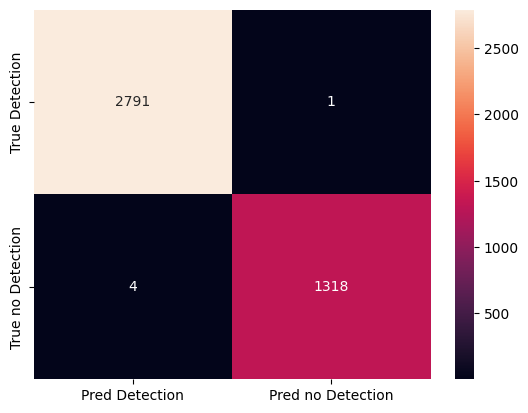

In [10]:
df_cm = pd.DataFrame(results, ['True Detection', 'True no Detection'],
                     ['Pred Detection', 'Pred no Detection'])

cm = sns.heatmap(df_cm, annot=True, fmt='g')

fig = cm.get_figure()
fig.savefig("/workspaces/MLOps_Project/pictures/EL123_confusion_matrix.png") 
fig.show()

### Scaled data

In [11]:
version=1
transformed_feature_view = fs.get_feature_view("transformed_parking_detection_fv", version=version)

In [12]:
t_X_train, t_X_test, t_y_train, t_y_test = transformed_feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (3.22s) 


In [13]:
t_y_train.value_counts(normalize=True)

mag_cluster 
detection       0.685768
no_detection    0.314232
Name: proportion, dtype: float64

In [14]:
t_model = KNeighborsClassifier(n_neighbors=2)
t_model.fit(t_X_train, t_y_train.values.ravel())

KNeighborsClassifier(n_neighbors=2)

In [15]:
t_y_pred = t_model.predict(t_X_test)
t_y_pred

array(['detection', 'no_detection', 'no_detection', ..., 'detection',
       'detection', 'detection'], dtype=object)

In [16]:
t_metrics = classification_report(t_y_test, t_y_pred, output_dict=True)
t_metrics

{'detection': {'precision': 0.9996408045977011,
  'recall': 1.0,
  'f1-score': 0.9998203700377223,
  'support': 2783.0},
 'no_detection': {'precision': 1.0,
  'recall': 0.9992486851990984,
  'f1-score': 0.9996242014280345,
  'support': 1331.0},
 'accuracy': 0.9997569275644141,
 'macro avg': {'precision': 0.9998204022988506,
  'recall': 0.9996243425995492,
  'f1-score': 0.9997222857328785,
  'support': 4114.0},
 'weighted avg': {'precision': 0.9997570148749156,
  'recall': 0.9997569275644141,
  'f1-score': 0.9997569037228232,
  'support': 4114.0}}

In [17]:
t_results = confusion_matrix(t_y_test, t_y_pred)
t_results

array([[2783,    0],
       [   1, 1330]])

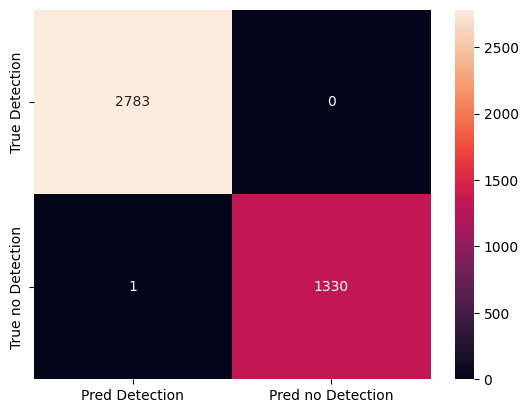

In [18]:
t_df_cm = pd.DataFrame(t_results, ['True Detection', 'True no Detection'],
                     ['Pred Detection', 'Pred no Detection'])

t_cm = sns.heatmap(t_df_cm, annot=True, fmt='g')

fig = t_cm.get_figure()
fig.savefig("/workspaces/MLOps_Project/pictures/EL123_transformed_confusion_matrix.png") 
fig.show()

## 3. Train and test datasets for new data

## 4. Uploading/updating models in the Feature Store

In [19]:
mr = project.get_model_registry()


Connected. Call `.close()` to terminate connection gracefully.


In [21]:
# The 'model' directory will be saved to the model registry
model_dir="models"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)
joblib.dump(model, model_dir + "/EL123_model.pkl")
shutil.copyfile("/workspaces/MLOps_Project/pictures/EL123_confusion_matrix.png", model_dir + "/EL123_confusion_matrix.png")

input_example = X_train.sample()
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

EL123_model = mr.python.create_model(
    version=2,
    name="EL123_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    input_example=input_example, 
    description="Magnetic Detections predictor",)

EL123_model.save(model_dir)

Uploading: 100.000%|██████████| 1136998/1136998 elapsed<00:02 remaining<00:003.37it/s]
Uploading: 100.000%|██████████| 18327/18327 elapsed<00:01 remaining<00:001,  3.37it/s]
Uploading: 100.000%|██████████| 1136998/1136998 elapsed<00:02 remaining<00:003.37it/s]
Uploading: 100.000%|██████████| 18129/18129 elapsed<00:01 remaining<00:001,  3.37it/s]
Uploading: 100.000%|██████████| 23/23 elapsed<00:01 remaining<00:0007<00:18,  4.63s/it]
Uploading: 100.000%|██████████| 378/378 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:16<00:00,  2.74s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/549014/models/EL123_model/2


Model(name: 'EL123_model', version: 2)

In [22]:
# The 'model' directory will be saved to the model registry
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)
joblib.dump(model, model_dir + "/EL123_transformed_model.pkl")
shutil.copyfile("/workspaces/MLOps_Project/pictures/EL123_transformed_confusion_matrix.png", model_dir + "/EL123_transformed_confusion_matrix.png")

input_example = t_X_train.sample()
input_schema = Schema(t_X_train)
output_schema = Schema(t_y_train)
model_schema = ModelSchema(input_schema, output_schema)

EL123_transformed_model = mr.python.create_model(
    version=1,
    name="EL123_transformed_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    input_example=input_example, 
    description="Magnetic Detections predictor trained on transformed data",)

EL123_transformed_model.save(model_dir)

Uploading: 100.000%|██████████| 1136998/1136998 elapsed<00:02 remaining<00:003.48it/s]
Uploading: 100.000%|██████████| 18784/18784 elapsed<00:01 remaining<00:001,  3.48it/s]
Uploading: 100.000%|██████████| 1136998/1136998 elapsed<00:01 remaining<00:003.48it/s]
Uploading: 100.000%|██████████| 18129/18129 elapsed<00:01 remaining<00:001,  3.48it/s]
Uploading: 100.000%|██████████| 24/24 elapsed<00:01 remaining<00:0007<00:17,  4.45s/it]
Uploading: 100.000%|██████████| 378/378 elapsed<00:01 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:16<00:00,  2.70s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/549014/models/EL123_transformed_model/1


Model(name: 'EL123_transformed_model', version: 1)

## **Next up:** 5: Model Deployment
Go to the 5_model_deployment.ipynb notebook